# Introduction to Bayesian Networks with the titanic dataset

## Section 1: Loading data 

In [14]:
import pandas as pd
import numpy as np
import pgmpy
from IPython.display import Image

In [12]:
notebook_path = '/Users/pavansangha/Desktop/BayesAI/bayesai.io/Notebooks/PGMs/prod_notebooks/'

* For now we want to train on complete data only. We know this is not always possible but it will make things simpler. 

In [13]:
df = pd.read_csv(notebook_path+'data/titanic.csv')
df = df[['Survived','Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]
df_train = df.dropna().copy()
df_test = df.drop(df_train.index).copy()

## Section 2: Preprocessing 

* We want to make sure our data is categorical, which may seem unsual as most of the time in ML we want to encode categorical data into numeric data. 

* Our preprocessing consists of a class per column. A mapper which is used to revert the categorical label back to an interpretable original value accessed by the getitem method. 

* The pd.cut method allows us 

In [9]:
# Add info for information accessing with __get__item()
class AgeProc:
    def __init__(self):
        self.mapper = {0: 'baby', 1: 'young_child', 2: 'child', 3: 'adult'}
    
    def __call__(self, df):
        df = df.copy()
        df.loc[:, 'Age'] = pd.cut(x=df.loc[:, "Age"], bins=[0, 2, 10, 18, 100], labels=[0, 1, 2, 3])
        return df
    
    def __getitem__(self,item):
        return self.mapper[item]

    
class SibSpProc:
    def __init__(self):
        self.mapper = {0: '0-1', 1: '1-3', 2: '3-8'}
    
    def __call__(self, df):
        df = df.copy()
        df.loc[:, 'SibSp'] = pd.cut(x=df.loc[:, "SibSp"], bins=[0, 1, 3, 8], labels=[0, 1, 2], right=False)
        return df
    
    def __getitem__(self,item):
        return self.mapper[item]

        
class FareProc:
    def __init__(self):
        self.mapper = {0: '<=15', 1: '15-50', 2: '>50'}
    
    def __call__(self, df):
        df = df.copy()
        df.loc[:, 'Fare'] = pd.cut(x=df.loc[:, "Fare"], bins=[0,15, 50, 1000], labels=[0, 1, 2], right=False)
        return df
    
    def __getitem__(self,item):
        return self.mapper[item]

    
class ParchProc:
    def __init__(self):
        self.mapper = {0: '0-1', 1: '1-3', 2: '3-8'}
    
    def __call__(self, df):
        df = df.copy()
        df.loc[:, 'Parch'] = pd.cut(x=df.loc[:, "Parch"], bins=[0, 1, 3, 8], labels=[0, 1, 2], right=False)
        return df
    
    def __getitem__(self,item):
        return self.mapper[item]


class SexProc:
    def __init__(self):
        self.mapper = {0:'male',1:'female'}
    
    def __call__(self,df):
        df = df.copy()
        df.loc[:,'Sex'] = df.loc[:,'Sex'].map({'male':0,'female':1})
        return df
    
    def __getitem__(self,item):
        return self.mapper[item]


In [15]:
ageproc,sibspproc,fareproc,parchproc,sexproc = (AgeProc(),SibSpProc(),FareProc(),ParchProc(),SexProc())

df_train = (df_train.pipe(ageproc)
 .pipe(sibspproc)
 .pipe(fareproc)
 .pipe(parchproc)
 .pipe(sexproc))

df_test = (df_test.pipe(ageproc)
 .pipe(sibspproc)
 .pipe(fareproc)
 .pipe(parchproc)
 .pipe(sexproc))

df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,NaN,1,1,0,0,S
1,1,1,NaN,1,1,0,0,C
2,1,3,NaN,1,0,0,0,S
3,1,1,NaN,1,1,0,0,S
4,0,3,NaN,1,0,0,0,S


## Section 3: Introduction to Bayesian Networks (BN)s

* Let $\mathcal{X} = \{Y,Pc,S,A,Sb,P,F,E\}$ represent the variables in our model, we haven't yet stated what our model is. Note $Y$ represents Survived since we commonly denote a target variable with $Y$.  

* In normal machine learning models we are interested in modelling the conditional $P(Y|Pc,S,A,Sb,P,F,E)$. But here we will learn the joint distribution $P(Y,Pc,S,A,Sb,P,F,E)$. 

* So how will we do this? Informally we want to create a graph structure $G$ which will be a directed acyclic graph (DAG) whose nodes represent the variables in $\mathcal{X}$ and the edges represent some sort of dependancy between them. We will explain this dependancy later on. 


* The role of the of a DAG $G$ whose nodes are the random variables in a set $\mathcal{X}$ is two fold:

 1. As a data structure that provides the skeleton for representing a joint distribution compactly in a factorized way;
 2. As a compact representation for a set of conditional independence assumptions about a distribution.

### Section 3.1: Why is independance important in probability ?

* Consider an example with 5 random variables $X_1,\ldots,X_5$ which are binary. Suppose i want to know the joint distribution $P(X_1,\ldots,X_5)$. If there is complete dependance between the variables i need a table with $2^{5}$ rows for each combinations of the $X_i$'s, and a probability $P_r$ (for the rth) for the rth row. 

* While 32 entries is not that large you can see if i had 100 binary variables this table will quickly get too large!

* Suppose now that each of the $X_i$'s are independant. All i need to know to calculate $P(X_1,\ldots,X_5)$ is $P(X_i = 1) = p_i$ for each $i = 1,\ldots,5$. This is because $P(X_1,\ldots,X_5) = \prod_{i=1}^5 P(X_i)$. Recall since $X_i$ is binary $P(X_i=0) = 1-p_i$. So in this case we only need to store $p_i$ for each $i$ which is 5 pieces of information. 

* So in the completely dependant scenario we are storing $2^5$ pieces of information (or $2^5-1$ technically since the last row ensures the sum of all rows is 1 in the joint table) and in the completely independant case i'm only storing $5$ this is a huge difference. 

* Clearly these two cases look at the absolute extremes. 

* By exploiting the independence structure in our distribution we can make some serios space savings in storing our distribution. This will mean we can query it much more efficiently. 



## Section 4 Bayesian Networks

$\textbf{Definition 4.1}$:A Bayesian network structure $G$ is a directed acyclic graph whose nodes represent random variables $X_1,\ldots,X_n$. Let $Pa_{X_i}^{G}$ denote the parents of $X_i$ in $G$, and $ND_{X_i}$ the variables in the graph that are not descendants of $X_i$. Then $G$ encodes the following set of conditional independance assumptions known as local Markov assumptions or the local independencies and are denoted $\mathcal{I}_{l}(G)$. 

$$\mathrm{For\;each\;variable\;} X_{i}: X_i \perp ND_{X_i} |Pa_{X_i}^G $$

### Section 4.1: Independence semantics over the titanic data set. 

* We have learnt that a Bayesian network structure is a graph that specifies local independence relations over a set of random variables. 

* Later on we will introduce a notion of global independance but for now we focus on local independence.

* Consider the following DAG on the titanic dataset, this DAG specifies a set of independence statements over the variables. Learning these statements is a subject in and of itself that we will look at later but for now take the statements as fact. 

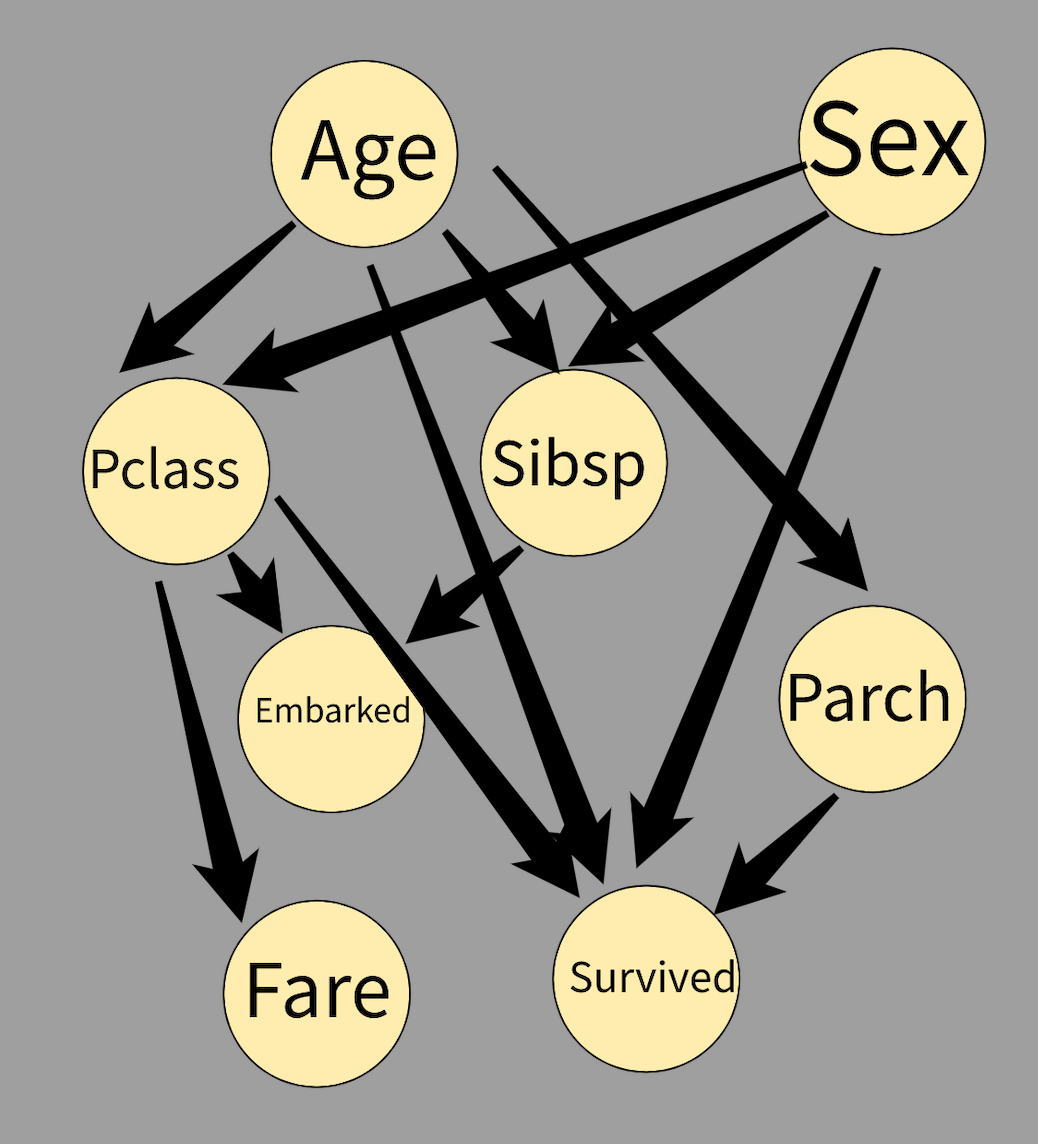

In [15]:
Image(notebook_path+"figs/BN_titanic.png",width = 300)

### Section 4.2: Defining edge structure in PGMPY

* We can create the graph above in PGMPY, we do this by adding the nodes and edges. 

In [16]:
from pgmpy.models import BayesianModel
model = BayesianModel()
model.add_nodes_from(['Survived','Pclass','Sex','Age','SibSp','Parch','Fare','Embarked'])
edges = [('Age','SibSp'),('Sex','Pclass'),('Age','Parch'),('Age','Survived'),('Age','Pclass'),('Sex','SibSp'),('Sex','Survived')
         ,('Pclass','Embarked'),('Pclass','Fare'),('Pclass','Survived'),('SibSp','Embarked'),('Parch','Survived')]
model.add_edges_from(edges)

* We can now read off the independence statements specified by the BN structure.  

* Lets list an example of an independance statement that belong to $\mathcal{I}_{l}(G)$ for the variables $\mathcal{X} = \{Y,Pc,S,A,Sb,P,F,E\}$. 

* $ND_{Sb} = \{P,Pc,F,Y\}$ and $Pa_{Sb} = \{A,S\}$ so the semantics tell us that $Sb \perp \{P,Pc,F,Y\} | \{A,S\}$

* This tells us if you give us the 'Age' and 'Sex' then we gain no more information from knowing 'Parch','Pclass','Fare','Survived' in determining 'SibSp'.

## Section 5: I-Maps and Factorisations 

### Section 5.1: I-maps 

* So so far we have not mentioned anything about a probability distribution over our variables $\{Y,Pc,S,A,Sb,P,F,E\}$ but now we will link the concept of a distribution $P$ and a BN structure $G$. 

$\textbf{Definition  5.1.1}$: Given a probability distribution $P$ lets denote the set of independance relations of the form $X \perp Y |Z$ by $\mathcal{I}(P)$. 

$\textbf{Definition  5.1.2}$: We can say that $P$ satisfies our local independence assumptions if $\mathcal{I}_{l}(G) \subset \mathcal{I}(P)$

* The above implies that the independence statements specified by $G$ hold in $P$ but it is important to note the converse does NOT necessarily hold. 

### Section 5.2: Defining a Bayesian Network 

* Lets now connect a probability distribution $P$ with our BN graph $G$. 

$\textbf{Definition 5.2.1}$: Let $G$ be a BN graph over the variables $X_1,\ldots, X_n$. We say that a distribution $P$ over the same space factorizes according to $G$ if $P$ can be expressed as a product $$P(X_1,\ldots,X_n) = \prod_{i=1}^n P(X_i|Pa_{X_i})$$

$\textbf{Definition 5.2.2}$: A Bayesian network is a pair $\mathcal{B} = (G,P)$ where $P$ factorizes over $G$, and where $P$ is specified as a set of CPD's associated with $Gs$'s nodes. 

### Section 5.3: I-map implies factorisation


$\textbf{Theorem 5.3.1}$: Let $G$ be a BN structure over a set of random variables $\mathcal{X}$ and let $P$ be a joint distribution over the same space. If $G$ is an $I$-map for $P$, then $P$ factorizes according to $G$. 

* The theorem above states that if $\mathcal{l}(G) \subset \mathcal{I}(P)$ then we can break the distribution of $P$ down into factors of the form specified above. 

$\textbf{Proof of Theorem 5.3.1}$: Let $X_1,\ldots,X_n$ be a topological ordering of the nodes (one where the parents of a node preceed the node in the ordering). We start by using the well known chain rule for probabilities 

$$P(X_1,\ldots,X_n) = \prod_{i=1}^n P(X_i|X_1,\ldots,X_{i-1}).$$

It suffices to consider a a single factor $P(X_i|X_1,\ldots,X_{i-1})$ we know by the Markov assumption that the independence statement $(X_i \perp ND_{X_i} | Pa_{X_i}) \in \mathcal{I}_{l}(G)$. Now since we have a topological ordering on the nodes we know that $Pa_{X_i} \subseteq \{X_1,\ldots,X_{i-1}\}$ and further more $\{X_1,\ldots,X_{i-1}\} = Pa_{X_i} \cup Z$ where $Z \subseteq ND_{X_i}$. From the fact $(X_i \perp ND_{X_i} | Pa_{X_i})$ that it follows that $(X_i \perp Z | Pa_{X_i})$ and thus 

$$P(X_i|X_1,\ldots,X_{i-1}) = P(X_i|Pa_{X_i},Z) = P(X_i |Pa_{X_i}).$$ We repeat this for each factor to obtain the required result. 

### Section 5.4: Factorisation implies I-map

* The converse of this statement also holds namely that a factorisation implies I-map.

$\textbf{Theorem 5.4.1}$: Let $G$ be a BN structure over a set of random variables $\mathcal{X}$ and let $P$ be a joint distribution over the same space. If $P$ factorizes according to $G$, then $G$ is an I-map for $P$. 

* $\textbf{Proof}$: For a given $X_i$ we want to show that if $P$ factorises over $G$ then $X_i \perp ND_{X_i}|Pa_{X_i}$. Start by marginalising over the variables which are the descendants of $X_i$ so that all we have left is $X_i, Pa_{X_i} and ND_{X_i}$. Do this by working backwards in the topological ordering of the vertices. In order from highest in the order to lowest. As an example consider we are looking at $C$ in the distribution $P(A,B,C,D,E) = P(A)P(B)P(C|A,B)P(D|A)P(E|C)$ in the topological ordering $E$ is a descendant of $C$ so to we can elimininate it to find $P(A,B,C,D) = P(A)P(B)P(C|A,B)P(D|A)\sum_{e} P(E|C)$ and since $P(E|C) = 1$ we get $$P(A,B,C,D) = P(A)P(B)P(C|A,B)P(D|A).$$ Graphically we can think of this as pruning the nodes below $X_i$ or $C$ in our example. Now let the remaining vertices (in $X_i, Pa_{X_i} and ND_{X_i}$) be numbered $X_1,\ldots,X_{i-1},X_{i},X_{i+1},\ldots,X_N$. We know that since $P$ factorizes over $G$ $$P(X_1,\ldots,X_N) = \prod_{j=1}^N P(X_j|Pa_{X_j})$$ and we want to show that $P(X_{i}|X_1,\ldots,X_{i-1},X_{i+1},\ldots,X_N) = P(X_{i}|Pa_{X_i})$. Now  
we know that $$P(X_{i}|X_1,\ldots,X_{i-1},X_{i+1},\ldots,X_N) = \frac{P(X_1,\ldots ,X_i,\ldots,X_N)}{P(X_1,\ldots,X_{i-1},X_{i+1},\ldots,X_{N})} = \frac{\prod_{j=1}^{N} P(X_j|pa_{X_i})}{\sum_{X_i}\prod_{j=1}^{N} P(X_j|pa_{X_i})} = \frac{P(X_{i}|Pa_{X_i}) \prod_{j=1,j \neq i}^{N} P(X_j|pa_{X_i})}{\prod_{j=1,j \neq i}^{N} P(X_j|pa_{X_i})} = P(X_i|Pa_{X_i}).$$

## Section 6: Summary

* A Bayesian Networks structure defines a graph over a set of random variables. This graph implies a set of local independencies of the form a node is indepdent of its non descendants given its parents. 

* We say that a distribution factorizes over a Bayesian Network structure if we can write its distribution as a product of local conditionals. 

* A Bayesian Network is a tuple consisting of a BN structure and a distribution which factorizes over it. 

* $(\textbf{Theorem 5.3.1})$ We showed if the independencies of a graph belong to the set of independencies of a distribution then the distribution factors according to the graph. 

* $(\textbf{Theorem 5.4.1})$ Conversely if a probability distribution factors according to a graph then the independencies of the graph belong to the set of independencies of the distribution. 